In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import keras
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
import numpy as np
import pandas as pd
from collections import defaultdict
import re


import sys
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from tensorflow.keras.layers import *
from keras.models import Model

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7205608608025380715
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14638920512
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5023615038526687008
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [ ]:
data_train = pd.read_csv('/content/gdrive/MyDrive/new/TanKianLong_1181300023/dataset/D4.csv')
data_train.text=data_train.text.astype(str)

In [ ]:
data_train.head()

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",washington reuters head conservative republica...,1
1,U.S. military to accept transgender recruits o...,washington reuters transgender people allow ti...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,washington reuters special counsel investigati...,1
3,FBI Russia probe helped by Australian diplomat...,washington reuters trump campaign adviser geor...,1
4,Trump wants Postal Service to charge 'much mor...,seattle washington reuters president donald tr...,1


In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74012 entries, 0 to 74011
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   74012 non-null  object
 1   text    74012 non-null  object
 2   label   74012 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [ ]:
# Convert to lowercase

data_train['text'] = data_train['text'].apply(lambda x: x.lower())
data_train.head()

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",washington reuters head conservative republica...,1
1,U.S. military to accept transgender recruits o...,washington reuters transgender people allow ti...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,washington reuters special counsel investigati...,1
3,FBI Russia probe helped by Australian diplomat...,washington reuters trump campaign adviser geor...,1
4,Trump wants Postal Service to charge 'much mor...,seattle washington reuters president donald tr...,1


In [ ]:
# Check
data_train.head()

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",washington reuters head conservative republica...,1
1,U.S. military to accept transgender recruits o...,washington reuters transgender people allow ti...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,washington reuters special counsel investigati...,1
3,FBI Russia probe helped by Australian diplomat...,washington reuters trump campaign adviser geor...,1
4,Trump wants Postal Service to charge 'much mor...,seattle washington reuters president donald tr...,1


In [ ]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data_train['text'] = data_train['text'].apply(punctuation_removal)

In [ ]:
# Check
data_train.head()

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",washington reuters head conservative republica...,1
1,U.S. military to accept transgender recruits o...,washington reuters transgender people allow ti...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,washington reuters special counsel investigati...,1
3,FBI Russia probe helped by Australian diplomat...,washington reuters trump campaign adviser geor...,1
4,Trump wants Postal Service to charge 'much mor...,seattle washington reuters president donald tr...,1


In [ ]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english','arabic')
stop.extend(["said", "reuters", "CNN", "would", "image", "via"])

data_train['text'] = data_train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data_train.head()

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",washington head conservative republican factio...,1
1,U.S. military to accept transgender recruits o...,washington transgender people allow time enlis...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,washington special counsel investigation link ...,1
3,FBI Russia probe helped by Australian diplomat...,washington trump campaign adviser george papad...,1
4,Trump wants Postal Service to charge 'much mor...,seattle washington president donald trump call...,1


In [ ]:
def clean_str(string):
    """
    Cleaning of dataset
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [ ]:
#print('What the raw input data looks like:')
#print(data_train[0:5])
texts = []
labels = []

for i in range(data_train.text.shape[0]):
    text2 = data_train.text[i]
    text =  str(text2)
    texts.append(text)
    labels.append(data_train.label[i])
    
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 251435 unique tokens.


In [ ]:
# Pad input sequences
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(labels),num_classes = 2)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (74012, 1000)
Shape of label tensor: (74012, 2)


In [ ]:
# Train test validation Split
from sklearn.model_selection import train_test_split

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train, x_test, y_train, y_test = train_test_split( data, labels, test_size=0.20, random_state=42)
x_test, x_val, y_test, y_val = train_test_split( x_test, y_test, test_size=0.50, random_state=42)
print('Size of train, validation, test:', len(y_train), len(y_val), len(y_test))

print('real & fake news in train,valt,test:')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))
print(y_test.sum(axis=0))

Size of train, validation, test: 59209 7402 7401
real & fake news in train,valt,test:
[29731. 29478.]
[3705. 3697.]
[3607. 3794.]


In [ ]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
from matplotlib import pyplot as plt
from keras.layers import Dense, Embedding, LSTM, GRU

%matplotlib inline

In [ ]:
GLOVE_DIR = "data" 
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, '/content/gdrive/My Drive/FYP/report/ALL/LSTM/glove.6B.100d.txt'), encoding="utf8") #The file that you had downloaded and moved from local session to drive.

In [ ]:
for line in f:
    values = line.split()
    #print(values[1:])
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove.' % len(embeddings_index))

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH)


Total 400000 word vectors in Glove.


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers

CNN

In [ ]:
embedding_vecor_length = 32
model = Sequential()
model.add(Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'))
model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [embedding_matrix], input_length = MAX_SEQUENCE_LENGTH, trainable=False,))
model.add(Dropout(0.2))
model.add(Conv1D(filters=128, kernel_size=3, padding='same',activation='relu')),
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add((LSTM(80, return_sequences=True)))
model.add(GlobalMaxPooling1D()),

model.add(Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2, activation="sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         25143600  
_________________________________________________________________
dropout (Dropout)            (None, 1000, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1000, 128)         38528     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 500, 128)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 500, 80)           66880     
_________________________________________________________________
global_max_pooling1d (Global (None, 80)                0

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=10, batch_size=128)

Epoch 1/10
463/463 [==============================] - 35s 58ms/step - loss: 0.7620 - accuracy: 0.7666 - val_loss: 0.2620 - val_accuracy: 0.9100
Epoch 2/10
463/463 [==============================] - 26s 57ms/step - loss: 0.2423 - accuracy: 0.9156 - val_loss: 0.1654 - val_accuracy: 0.9458
Epoch 3/10
463/463 [==============================] - 27s 58ms/step - loss: 0.1762 - accuracy: 0.9396 - val_loss: 0.1461 - val_accuracy: 0.9477
Epoch 4/10
463/463 [==============================] - 26s 57ms/step - loss: 0.1484 - accuracy: 0.9485 - val_loss: 0.1284 - val_accuracy: 0.9535
Epoch 5/10
463/463 [==============================] - 26s 57ms/step - loss: 0.1327 - accuracy: 0.9547 - val_loss: 0.1285 - val_accuracy: 0.9501
Epoch 6/10
463/463 [==============================] - 27s 57ms/step - loss: 0.1221 - accuracy: 0.9589 - val_loss: 0.1501 - val_accuracy: 0.9453
Epoch 7/10
463/463 [==============================] - 27s 57ms/step - loss: 0.1125 - accuracy: 0.9610 - val_loss: 0.1186 - val_accuracy:

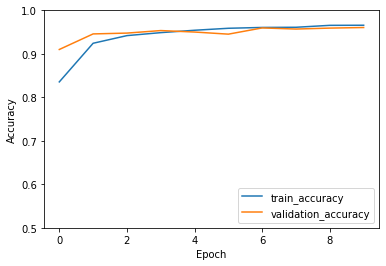

In [ ]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

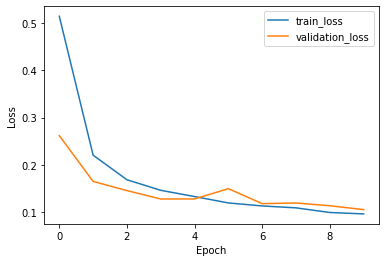

In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
y_pred = model.predict_classes(x_val)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
test_preds = model.predict(x_test)
test_preds = np.round(test_preds)
correct_predictions = float(sum(test_preds == y_test)[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model1: ", correct_predictions/float(len(y_test)))

Correct predictions: 7137.0
Total number of test examples: 7401
Accuracy of model1:  0.9643291447101743


In [ ]:
y_test[1]

array([1., 0.], dtype=float32)

In [ ]:
import numpy as np
rounded_labels=np.argmax(y_test, axis=1)

In [ ]:
rounded_labels

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict_classes(x_test)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
print(classification_report(rounded_labels, y_pred, target_names=['negative','positive']))

              precision    recall  f1-score   support

    negative       0.95      0.98      0.96      3607
    positive       0.98      0.95      0.97      3794

    accuracy                           0.96      7401
   macro avg       0.96      0.96      0.96      7401
weighted avg       0.96      0.96      0.96      7401

